In [1]:
import torch, torchvision
import torch.nn as nn
import numpy as np
import PIL.Image as Image
import torchvision
import os, random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import glob

In [2]:
class ResNet152decoders(nn.Module):
    def __init__(self, imagenet_pt, num_outputs=1, **kwargs):
        super().__init__()
        self.net = torchvision.models.resnet152(pretrained=imagenet_pt, progress=True, **kwargs)
        self.decoders = nn.ModuleList([nn.Linear(224*224*3, num_outputs),
                                      nn.Linear(802816, num_outputs),
                                      nn.Linear(401408, num_outputs),
                                      nn.Linear(200704, num_outputs),
                                      nn.Linear(100352, num_outputs),
                                      nn.Linear(2048, num_outputs)])

    def forward(self, x):
        out_dec = []
        out_dec.append(self.decoders[0](torch.flatten(x, 1)).squeeze())

        x = self.net.conv1(x)
        x = self.net.bn1(x)
        x = self.net.relu(x)
        x = self.net.maxpool(x)

        x = self.net.layer1(x)
        out_dec.append(self.decoders[1](torch.flatten(x, 1)).squeeze())

        x = self.net.layer2(x)
        out_dec.append(self.decoders[2](torch.flatten(x, 1)).squeeze())

        x = self.net.layer3(x)
        out_dec.append(self.decoders[3](torch.flatten(x, 1)).squeeze())

        x = self.net.layer4(x)
        out_dec.append(self.decoders[4](torch.flatten(x, 1)).squeeze())

        x = self.net.avgpool(x)
        x = torch.flatten(x, 1)
        out_dec.append(self.decoders[5](torch.flatten(x, 1)).squeeze())
        return out_dec

In [3]:
def scale_choices(choices, scale='linear', method='class'):
    odd_choices = True # Flag indicates whether choice categories are 1, 3, 5, 7,...
    length_unit = 8 # Number of pixels per unit -- this depends on how data was generated
    scaled_choices = []
    for choice in choices:
        if  method == 'class':
            if odd_choices is True:
                choice = (2 * choice) + 1 # Convert from 0, 1, 2, 3... to 1, 3, 5, 7,...
            if scale == 'linear':
                scaled_choice = choice * length_unit
                scaled_choices.append(scaled_choice)
            elif scale == 'log':
                scaled_choice = np.log(choice * length_unit)
                scaled_choices.append(scaled_choice)
        elif method == 'regr':
            if scale == 'linear':
                scaled_choice = choice * length_unit
                scaled_choices.append(scaled_choice)
            elif scale == 'log':
                scaled_choice = np.log(choice * length_unit)
                scaled_choices.append(scaled_choice)
    
    return scaled_choices


def get_test_outputs(net, targets, base_dir, scale, method='class'):
    imagenet_stats = {'mean': [0.491, 0.482, 0.44], 'std': [0.247, 0.243, 0.262]}
    tt = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=imagenet_stats['mean'], std=imagenet_stats['std'])])

    df = pd.DataFrame(columns=['target', 'trial', 'choice', 'decoder'])
    for target in targets:
        ntest = 100 
        choices = np.zeros(shape=(1,ntest))
        for ii in range(ntest):
            if method == 'class':
                target_dir = os.path.join(base_dir, 'test', str(target).zfill(2))
                img = Image.open(os.path.join(target_dir, random.choice(os.listdir(target_dir))))
                img = tt(img).unsqueeze(0)
                output = net(img)
                choice1 = int(torch.argmax(output[1]).cpu().detach().numpy())
                choice2 = int(torch.argmax(output[2]).cpu().detach().numpy())
                choice3 = int(torch.argmax(output[3]).cpu().detach().numpy())
                choice4 = int(torch.argmax(output[4]).cpu().detach().numpy())
            elif method == 'regr':
                target_dir = os.path.join(base_dir, 'test')
                file_regex = str(target) + '.*.png'
                files_match = glob.glob(os.path.join(target_dir, file_regex))
                img = Image.open(random.choice(files_match))
                img = tt(img).unsqueeze(0)
                output = net(img)
                choice1 = np.ndarray.round(output[1].cpu().detach().numpy())
                choice2 = np.ndarray.round(output[2].cpu().detach().numpy())
                choice3 = np.ndarray.round(output[3].cpu().detach().numpy())
                choice4 = np.ndarray.round(output[4].cpu().detach().numpy())

            scaled_choices = scale_choices([choice1, choice2, choice3, choice4], scale=scale, method=method) # convert from 0, 1, 2 to actual line lengths (in pixels)

            df = df.append(pd.DataFrame([[target, ii, scaled_choices[0], 1]], columns=['target', 'trial', 'choice', 'decoder']), ignore_index=True)
            df = df.append(pd.DataFrame([[target, ii, scaled_choices[1], 2]], columns=['target', 'trial', 'choice', 'decoder']), ignore_index=True)
            df = df.append(pd.DataFrame([[target, ii, scaled_choices[2], 3]], columns=['target', 'trial', 'choice', 'decoder']), ignore_index=True)
            df = df.append(pd.DataFrame([[target, ii, scaled_choices[3], 4]], columns=['target', 'trial', 'choice', 'decoder']), ignore_index=True)
    return df


def normal(mean, std, ax, color="black"):
    '''
    Fit a normal distribution for a given observed mean and standard deviation
    '''
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    z = ax.plot(x, p, color=color , linewidth=2)


def plot_hist_normal(df, targets, scale='linear'):
    '''
    Plot a histogram of outputs for given targets (test categories) and overlay normal distributions
    df = dataframe with [trial, target, choice, decoder] as columns and trial as rows
    '''
    fig, axes = plt.subplots(1, 4, sharex=True, figsize=(20,5))
    my_palette = sns.husl_palette(len(targets))
    lu = 8 # Number of pixels per unit -- this depends on how data was generated; from create_weber_stim: get_params()['length_unit']

    if scale == 'linear':
        plt.xlim((lu, 20 * lu))
        ticks = [lu] + [ii*lu for ii in targets] + [20*lu]
        plt.xticks(np.asarray(ticks), labels=np.asarray(ticks))
        # plt.xticks(np.arange(lu, 21*lu, step=2*lu))
    elif scale == 'log':
        plt.xlim((np.log(lu), np.log(20 * lu)))
        ticks = [lu] + [ii*lu for ii in targets] + [20*lu]
        plt.xticks(np.log(np.asarray(ticks)), labels=np.asarray(ticks))

    for dd in range(1, 5): # for all decoders
        if scale == 'linear':
            bins = np.arange(0, 21*lu, step=2*lu)
        elif scale == 'log':
            bins = np.log(np.arange(0.1, 21*lu, step=2*lu))
        sns.histplot(data = df.loc[df['decoder']==dd], x='choice', bins=bins, hue='target', palette=my_palette, alpha=0.7, stat='density', ax=axes[dd-1])
        for tix,target in enumerate(targets):
            data_decoder_dd_target_tt = df.loc[(df['decoder']==dd) & (df['target']==target)]
            normal(data_decoder_dd_target_tt['choice'].mean(), data_decoder_dd_target_tt['choice'].std(), ax=axes[dd-1], color=my_palette[tix])


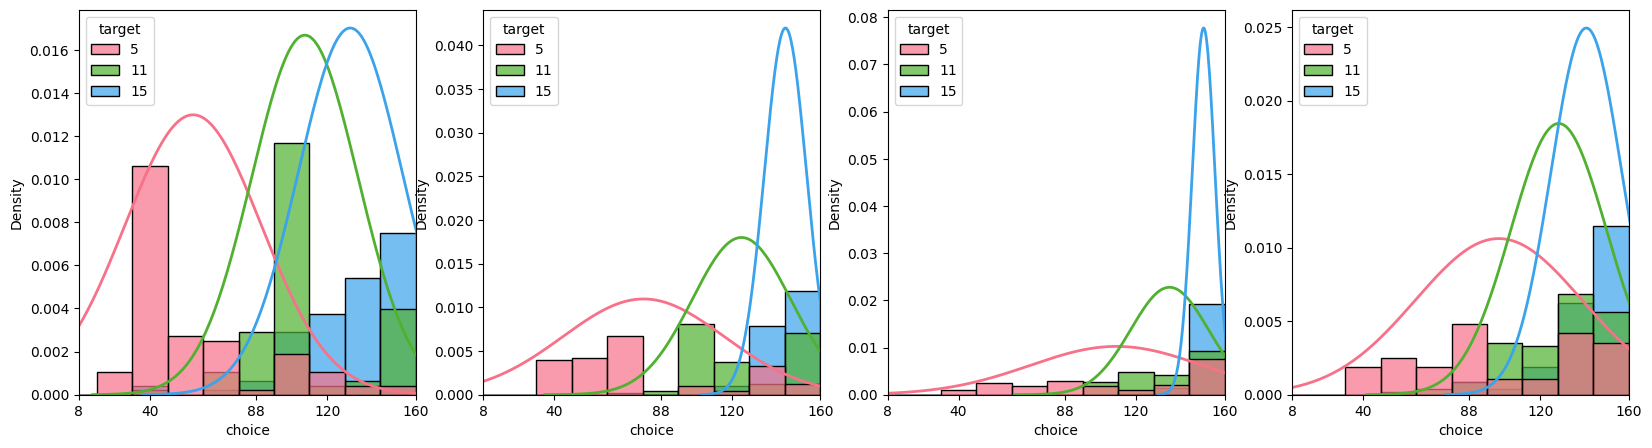

In [4]:
net = ResNet152decoders(imagenet_pt=False, num_outputs=10)

targets = [5, 11, 15]
scale = 'linear'
dataset = 'length_all_vars'
model_dir = os.path.join('./mind-set/models/', dataset)
data_dir = os.path.join('./mind-set/data/', dataset)
net.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt'))['model'])
df = get_test_outputs(net, targets, data_dir, scale)

plot_hist_normal(df, targets, scale=scale)

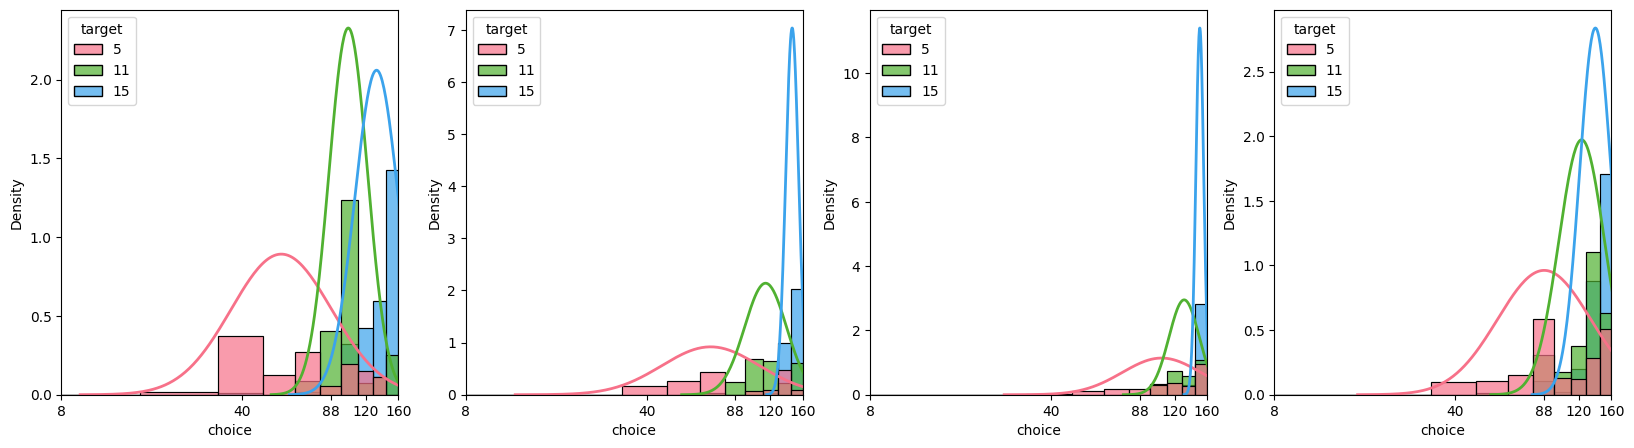

In [5]:
net = ResNet152decoders(imagenet_pt=False, num_outputs=10)

targets = [5, 11, 15]
scale = 'log'
dataset = 'length_all_vars'
model_dir = os.path.join('./mind-set/models/', dataset)
data_dir = os.path.join('./mind-set/data/', dataset)
net.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt'))['model'])
df = get_test_outputs(net, targets, data_dir, scale)

plot_hist_normal(df, targets, scale=scale)

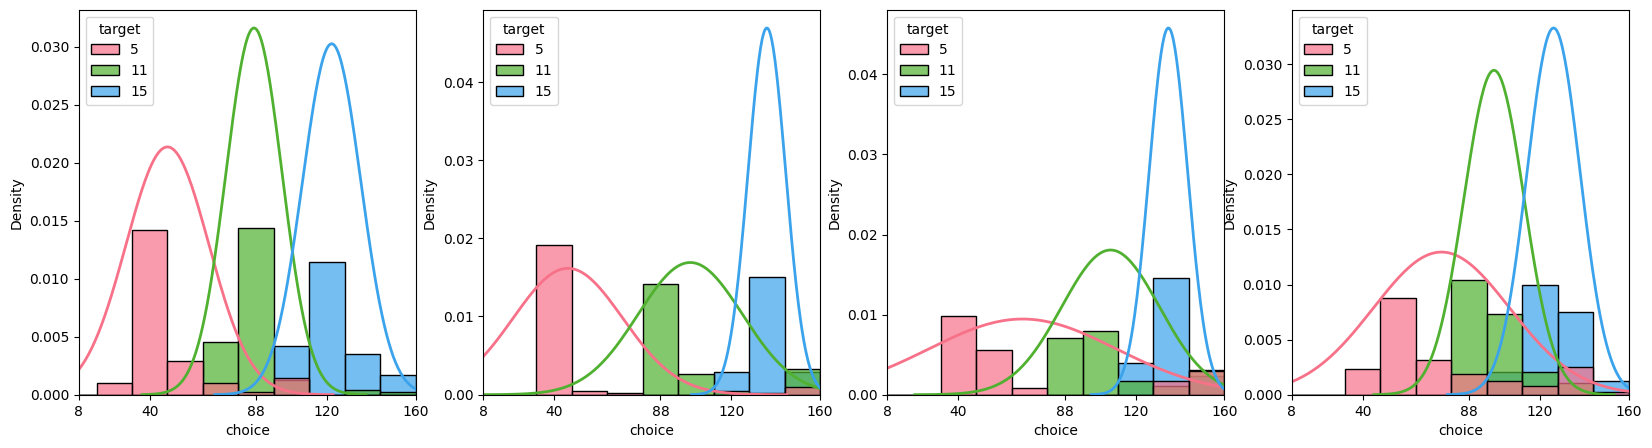

In [6]:
net = ResNet152decoders(imagenet_pt=False, num_outputs=10)

targets = [5, 11, 15]
scale = 'linear'
dataset = 'length_simple_odd'
model_dir = os.path.join('./mind-set/models/', dataset)
data_dir = os.path.join('./mind-set/data/', dataset)
net.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt'))['model'])
df = get_test_outputs(net, targets, data_dir, scale)

plot_hist_normal(df, targets, scale=scale)

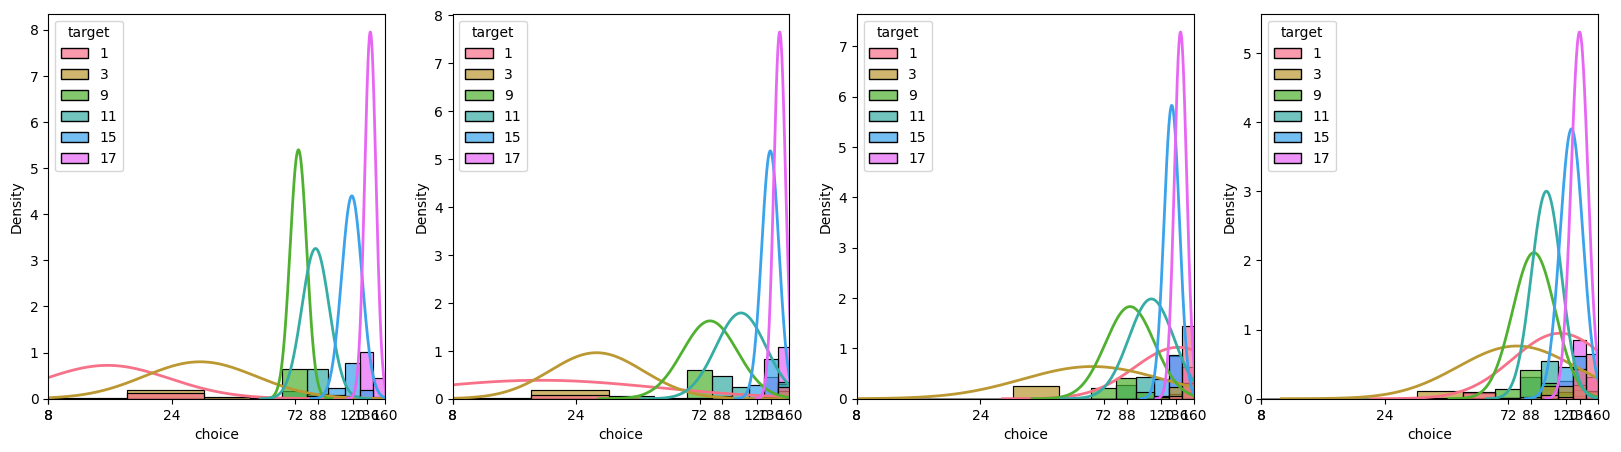

In [7]:
net = ResNet152decoders(imagenet_pt=False, num_outputs=10)

targets = [1, 3, 9, 11, 15, 17]
scale = 'log'
dataset = 'length_simple_odd'
model_dir = os.path.join('./mind-set/models/', dataset)
data_dir = os.path.join('./mind-set/data/', dataset)
net.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt'))['model'])
df = get_test_outputs(net, targets, data_dir, scale)

plot_hist_normal(df, targets, scale=scale)

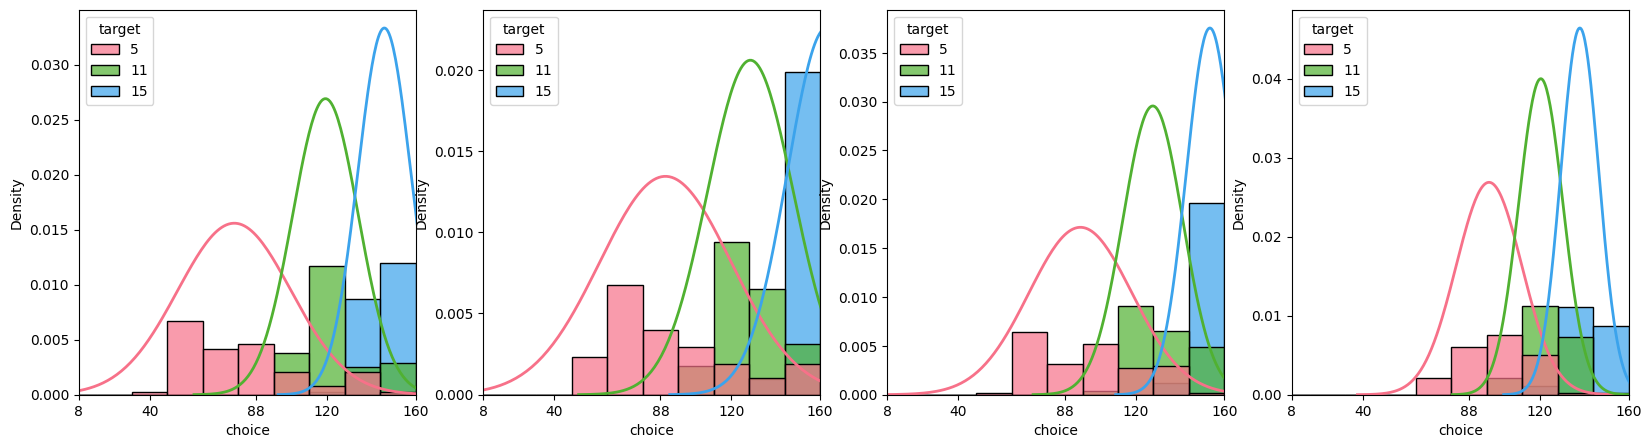

In [4]:
'''Regression'''
net = ResNet152decoders(imagenet_pt=False, num_outputs=1)

targets = [5, 11, 15]
scale = 'linear'
dataset = 'length'
model_dir = os.path.join('./mind-set/models/', dataset)
data_dir = os.path.join('./mind-set/data/', dataset)
net.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt'))['model'])
df = get_test_outputs(net, targets, data_dir, scale, method='regr')

plot_hist_normal(df, targets, scale=scale)